# Intro

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import common
common.configure_logging(level='debug')

DEBUG:root:Done configuring logging!


In [6]:
from biodata import *

In [9]:
import az_dream.functions as fn

In [10]:
%matplotlib inline

# Load data

## Cell info

In [11]:
cell_info = pd.read_csv(
    '../downloads/challenge_data/sanger_molecular_data/'
    'cell_info.csv/cell_info.csv',
    sep=',',
)

In [12]:
cell_info = cell_info.rename(columns={
    'Sanger.Name': 'c',
    'CCLE.Name': 'cell_line_ccle',
    'Alternative.Name': 'cell_line_alternative',
    'Disease.Area': 'cell_line_disease_area',
    'Tissue..General.': 'cell_line_tissue',
    'COSMIC': 'cell_line_cosmic',
})

In [13]:
cell_info.head()

,c,cell_line_ccle,cell_line_alternative,cell_line_disease_area,cell_line_tissue,cell_line_cosmic
0,22RV1,22RV1_PROSTATE,22RV1,Urology,male genital system,924100
1,647-V,647V_URINARY_TRACT,647V,Urology,urinary tract,906797
2,A549,A549_LUNG,A549,Lung,lung,905949
3,BFTC-905,BFTC905_URINARY_TRACT,BFTC905,Urology,urinary tract,910926
4,BT-20,BT20_BREAST,BT20,Breast,breast,906801


In [14]:
Counter(cell_info['cell_line_disease_area'])

Counter({'Breast': 34,
         'GI': 12,
         'Haems': 1,
         'Lung': 22,
         'Niche': 2,
         'Urology': 14})

In [18]:
Counter(cell_info['cell_line_tissue'])

Counter({'blood/lymph': 1,
         'breast': 34,
         'gastrointestinal tract (lower)': 10,
         'gastrointestinal tract (upper)': 2,
         'lung': 22,
         'male genital system': 2,
         'soft tissue': 2,
         'urinary tract': 12})

In [16]:
cell_info['disease_area_breast'] = (cell_info['cell_line_disease_area'] == 'Breast').astype(int)
cell_info['disease_area_gi'] = (cell_info['cell_line_disease_area'] == 'GI').astype(int)
cell_info['disease_area_lung'] = (cell_info['cell_line_disease_area'] == 'Lung').astype(int)
cell_info['disease_area_urology'] = (cell_info['cell_line_disease_area'] == 'Urology').astype(int)

In [17]:
cell_info.head()

,c,cell_line_ccle,cell_line_alternative,cell_line_disease_area,cell_line_tissue,cell_line_cosmic,disease_area_breast,disease_area_gi,disease_area_lung,disease_area_urology
0,22RV1,22RV1_PROSTATE,22RV1,Urology,male genital system,924100,0,0,0,1
1,647-V,647V_URINARY_TRACT,647V,Urology,urinary tract,906797,0,0,0,1
2,A549,A549_LUNG,A549,Lung,lung,905949,0,0,1,0
3,BFTC-905,BFTC905_URINARY_TRACT,BFTC905,Urology,urinary tract,910926,0,0,0,1
4,BT-20,BT20_BREAST,BT20,Breast,breast,906801,1,0,0,0


## CSS

In [9]:
css = pd.read_sql_query("""\
SELECT c, avg(synergy_score) synergy_score
FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY
where synergy_score is not null
group by c;
""", sa.create_engine(os.environ['BIODB_CONNECTION_STR'] + '/az_dream_2015'))

In [10]:
css = css.set_index('c')['synergy_score']

In [11]:
css.head()

c
22RV1       -8.601674
647-V       13.834063
A549        21.671942
BFTC-905    21.839952
BT-20       22.283808
Name: synergy_score, dtype: float64

## GSS

In [12]:
dss = pd.read_sql_query("""\
SELECT d, avg(synergy_score) synergy_score
FROM (
    SELECT d_1 d, synergy_score
    FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY
    where synergy_score is not null
    UNION ALL
    SELECT d_2 d, synergy_score
    FROM az_dream_2015.ALL_TRAINING_DATA_WSYNERGY
    where synergy_score is not null
) t
group by d;
""", sa.create_engine(os.environ['BIODB_CONNECTION_STR'] + '/az_dream_2015'))

In [13]:
dss = dss.set_index('d')

In [14]:
dss.head()

,synergy_score
d,
ADAM17,3.639117
AKT,4.981951
AKT_1,12.759452
AKT_SGK,9.716044
ALK,12.950270


## Mutations

In [15]:
mutations = pd.read_csv(
    '../downloads/challenge_data/sanger_molecular_data/'
    'mutations.csv/mutations.csv',
    sep=',', low_memory=False,
)

In [16]:
mutations = mutations.rename(columns={
    'Gene.name': 'g',
    'cell_line_name': 'c',
})

In [17]:
display(mutations.head(2))
print(mutations.shape)

,g,Accession.Number,Gene.CDS.length,HGNC.ID,c,ID_sample,ID_tumour,Primary.site,Site.subtype,Primary.histology,Histology.subtype,Genome.wide.screen,Mutation.ID,Mutation.CDS,Mutation.AA,Mutation.Description,Mutation.zygosity,GRCh,Mutation.genome.position,strand,SNP,FATHMM.prediction,Mutation.somatic.status,Pubmed_PMID,ID_STUDY,Institute,Institute.Address,Catalogue.Number,Sample.source,Tumour.origin,Age,Comments
0,FRMD4A,ENST00000357447,3120,25491,HCC1806,907047,824559,breast,NS,carcinoma,ductal_carcinoma,y,COSM109920,c.1049C>T,p.S350L,Substitution - Missense,het,38,10:13693966-13693966,-,n,PASSENGER/OTHER,Reported in another cancer sample as somatic,NaN,NaN,American Type Culture Collection (ATCC),"P.O. Box 1549, Manassas, VA 20108, USA",CRL-2335,cell-line,primary,60,"Grade:II,Stage:II"
1,LILRB1,ENST00000396331,1953,6605,HCC1806,907047,824559,breast,NS,carcinoma,ductal_carcinoma,y,COSM162161,c.1690G>A,p.E564K,Substitution - Missense,het,38,19:54636536-54636536,+,n,PASSENGER/OTHER,Reported in another cancer sample as somatic,NaN,NaN,American Type Culture Collection (ATCC),"P.O. Box 1549, Manassas, VA 20108, USA",CRL-2335,cell-line,primary,60,"Grade:II,Stage:II"


(75281, 32)


In [18]:
mutations.columns = [c.replace('.', '_').lower() for c in mutations.columns]

In [19]:
mutations.head(2)

,g,accession_number,gene_cds_length,hgnc_id,c,id_sample,id_tumour,primary_site,site_subtype,primary_histology,histology_subtype,genome_wide_screen,mutation_id,mutation_cds,mutation_aa,mutation_description,mutation_zygosity,grch,mutation_genome_position,strand,snp,fathmm_prediction,mutation_somatic_status,pubmed_pmid,id_study,institute,institute_address,catalogue_number,sample_source,tumour_origin,age,comments
0,FRMD4A,ENST00000357447,3120,25491,HCC1806,907047,824559,breast,NS,carcinoma,ductal_carcinoma,y,COSM109920,c.1049C>T,p.S350L,Substitution - Missense,het,38,10:13693966-13693966,-,n,PASSENGER/OTHER,Reported in another cancer sample as somatic,NaN,NaN,American Type Culture Collection (ATCC),"P.O. Box 1549, Manassas, VA 20108, USA",CRL-2335,cell-line,primary,60,"Grade:II,Stage:II"
1,LILRB1,ENST00000396331,1953,6605,HCC1806,907047,824559,breast,NS,carcinoma,ductal_carcinoma,y,COSM162161,c.1690G>A,p.E564K,Substitution - Missense,het,38,19:54636536-54636536,+,n,PASSENGER/OTHER,Reported in another cancer sample as somatic,NaN,NaN,American Type Culture Collection (ATCC),"P.O. Box 1549, Manassas, VA 20108, USA",CRL-2335,cell-line,primary,60,"Grade:II,Stage:II"


## Gene subsets

### CGS

In [20]:
engine = sa.create_engine(os.environ['BIODB_CONNECTION_STR'] + '/cosmic')
cancer_gene_census = pd.read_sql_table('cancer_gene_census', engine)

In [21]:
cancer_gene_census.head(2)

,gene_symbol,name,entrez_geneid,genome_location,chr_band,somatic,germline,tumour_types_somatic,tumour_types_germline,cancer_syndrome,tissue_type,molecular_genetics,mutation_types,translocation_partner,other_germline_mut,other_syndrome,synonyms
0,ABI1,abl-interactor 1,10006,10:26748570-26860863,10p11.2,yes,None,AML,None,None,L,Dom,T,KMT2A,None,None,"ABI1,E3B1,ABI-1,SSH3BP1,10006"
1,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,9q34.1,yes,None,"CML, ALL, T-ALL",None,None,L,Dom,"T, Mis","BCR, ETV6, NUP214",None,None,"ABL1,p150,ABL,c-ABL,JTK7,bcr/abl,v-abl,P00519,..."


In [22]:
cgs_genes = set(cancer_gene_census['gene_symbol'])

### Target

In [23]:
engine = sa.create_engine(os.environ['BIODB_CONNECTION_STR'] + '/az_dream_2015')
drug_to_hgnc_target = pd.read_sql_table('drug_to_hgnc_target', engine)
drug_to_hgnc_target.head(2)

,drug,hgnc_name
0,ADAM17,ADAM17
1,AKT,AKT1


In [24]:
target_genes = set(drug_to_hgnc_target['hgnc_name'])

# Cell line info

## Useless

In [25]:
mutations['c'].drop_duplicates().shape

(85,)

In [26]:
mutations[['c', 'id_sample']].drop_duplicates().shape

(85, 2)

In [27]:
mutations[['c', 'id_tumour']].drop_duplicates().shape

(85, 2)

In [28]:
mutations[['c', 'sample_source']].drop_duplicates().shape

(85, 2)

In [29]:
Counter(mutations['sample_source'])

Counter({'cell-line': 75281})

In [30]:
mutations[['c', 'genome_wide_screen']].drop_duplicates().shape

(85, 2)

In [31]:
Counter(mutations['genome_wide_screen'].values)

Counter({'y': 75281})

In [32]:
mutations[['c', 'comments']].drop_duplicates().shape

(85, 2)

In [33]:
Counter(mutations['comments'])

Counter({nan: 46102,
         'Metastatic site:stomach': 383,
         'Metastatic site:pleural effusion': 9292,
         'Stage:I': 387,
         'Stage:IV': 1611,
         'Metastatic site:lymph node': 1728,
         'Grade:I,Metastatic site:NA': 980,
         'Metastatic site:central nervous system': 1985,
         'Grade:II,Stage:II': 558,
         'Grade:III,Metastatic site:lymph node,Stage:III': 937,
         'Stage:III,Metastatic site:NA': 530,
         'Grade:II,Stage:IV': 611,
         'Grade:IV,Metastatic site:lymph node,Stage:III': 2837,
         'Metastatic site:skin': 460,
         'Metastatic site:ascites': 591,
         'Metastatic site:ascitic fluid': 1044,
         'Metastatic site:mediastinum': 516,
         'Stage:III': 2902,
         'Stage:II': 908,
         'Grade:II,Stage:III': 215,
         'Metastatic site:bone marrow': 704})

## Useful

In [34]:
Counter(mutations['tumour_origin'])

Counter({'NS': 4069, 'metastasis': 16529, 'primary': 54683})

In [35]:
mutations[['c', 'age']].drop_duplicates().shape

(85, 2)

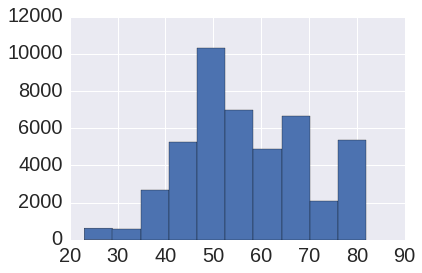

In [36]:
mutations['age'].hist()

In [37]:
mutations[['c', 'primary_histology']].drop_duplicates().shape

(85, 2)

In [38]:
Counter(mutations['primary_histology'].values)

Counter({'carcinoma': 70922,
         'lymphoid_neoplasm': 1212,
         'malignant_melanoma': 3147})

In [39]:
mutations[['c', 'histology_subtype']].drop_duplicates().shape

(85, 2)

In [40]:
Counter(mutations['histology_subtype'].values)

Counter({'NS': 30985,
         'adenocarcinoma': 17017,
         'bronchioloalveolar_adenocarcinoma': 1693,
         'ductal_carcinoma': 9286,
         'mixed_adenosquamous_carcinoma': 980,
         'non_small_cell_carcinoma': 8347,
         'plasma_cell_myeloma': 1212,
         'small_cell_carcinoma': 516,
         'squamous_cell_carcinoma': 734,
         'transitional_cell_carcinoma': 4511})

# Mutation info

## mutation_description

In [41]:
Counter(mutations['mutation_description'].values)

Counter({'Complex - compound substitution': 1,
         'Complex - deletion inframe': 28,
         'Complex - frameshift': 33,
         'Complex - insertion inframe': 1,
         'Deletion - Frameshift': 3017,
         'Deletion - In frame': 334,
         'Insertion - Frameshift': 1029,
         'Insertion - In frame': 102,
         'Nonstop extension': 53,
         'Substitution - Missense': 43378,
         'Substitution - Nonsense': 2609,
         'Substitution - coding silent': 18537,
         'Unknown': 6159})

In [42]:
mutations['f_mutation_very_bad'] = (
    (mutations['mutation_description'] == 'Complex - compound substitution') |
    (mutations['mutation_description'] == 'Complex - deletion inframe') |
    (mutations['mutation_description'] == 'Complex - frameshift') | 
    (mutations['mutation_description'] == 'Complex - insertion inframe') | 
    (mutations['mutation_description'] == 'Deletion - Frameshift') | 
    (mutations['mutation_description'] == 'Insertion - Frameshift') |
    (mutations['mutation_description'] == 'Substitution - Nonsense')
).astype(int)

mutations['f_mutation_maybe_bad'] = (
    (mutations['mutation_description'] == 'Deletion - In frame') |
    (mutations['mutation_description'] == 'Insertion - In frame') |
    (mutations['mutation_description'] == 'Nonstop extension') | 
    (mutations['mutation_description'] == 'Substitution - Missense')
).astype(int)

mutations['f_mutation_mild'] = (
    (mutations['mutation_description'] == 'Substitution - coding silent')
).astype(int)

## mutation_zygosity

In [43]:
Counter(mutations['mutation_zygosity'].values)

Counter({'het': 68066, 'hom': 7215})

In [44]:
mutations['f_homozygous'] = (mutations['mutation_zygosity'] == 'hom').astype(int)

## snp

In [45]:
Counter(mutations['snp'].values)

Counter({nan: 2098, 'y': 1791, 'n': 71392})

In [46]:
mutations['f_snp'] = (mutations['snp'] == 'y').astype(int)

## fathmm_prediction

In [47]:
Counter(mutations['fathmm_prediction'].values)

Counter({nan: 70187, 'CANCER': 658, 'PASSENGER/OTHER': 4436})

## mutation_somatic_status

In [48]:
Counter(mutations['mutation_somatic_status'].values)

Counter({'Confirmed somatic variant': 160,
         'Reported in another cancer sample as somatic': 7618,
         'Variant of unknown origin': 67503})

In [49]:
mutations['f_maybe_somatic'] = (
    (mutations['mutation_somatic_status'] == 'Confirmed somatic variant') | 
    (mutations['mutation_somatic_status'] == 'Reported in another cancer sample as somatic')
).astype(int)

# Save

In [26]:
import csv2sql
db = csv2sql.DataFrameToMySQL(
    os.environ['BIODB_CONNECTION_STR'] + '/az_dream_2015_features', 
    'cnv', 
    os.environ['STG_SERVER_IP'], 
    echo=False
)

In [22]:
import csv2sql.g2d

## gc

In [52]:
mutations_gbgc_gp = (
    mutations
    .groupby(['g', 'gene_cds_length', 'c'])
)

In [53]:
mutations_gbgc = (
    mutations_gbgc_gp
    .agg({
        'mutation_aa': 'count',
        'f_maybe_somatic': 'sum',
        'f_snp': 'sum',
        'f_homozygous': 'sum',
        'f_mutation_very_bad': 'sum',
        'f_mutation_maybe_bad': 'sum',
        'f_mutation_mild': 'sum',
    }).rename(columns={'mutation_aa': 'f_mutation'})
    .reset_index()
)

In [54]:
columns_to_drop = ['gene_cds_length']
for column in mutations_gbgc:
    if not column.startswith('f_'):
        continue
    mutations_gbgc[column + '_density'] = mutations_gbgc[column] / mutations_gbgc['gene_cds_length']
    columns_to_drop.append(column)

mutations_gbgc.drop(pd.Index(columns_to_drop), axis=1, inplace=True)
mutations_gbgc.columns = [((c + '_gbgc') if c not in ['g', 'c'] else c) for c in mutations_gbgc.columns]

In [55]:
mutations_gbgc.head(10)

,g,c,f_mutation_maybe_bad_density_gbgc,f_snp_density_gbgc,f_maybe_somatic_density_gbgc,f_mutation_mild_density_gbgc,f_mutation_very_bad_density_gbgc,f_mutation_density_gbgc,f_homozygous_density_gbgc
0,A1BG,CAL-51,0.000000,0,0,0.000672,0,0.000672,0
1,A1BG,HCC1500,0.000000,0,0,0.000672,0,0.000672,0
2,A1BG,HCC1806,0.000000,0,0,0.000672,0,0.000672,0
3,A1BG,MDA-MB-415,0.000000,0,0,0.000672,0,0.000672,0
4,A1BG,RKO,0.000672,0,0,0.000000,0,0.000672,0
5,A1CF,22RV1,0.000568,0,0,0.000000,0,0.000568,0
6,A1CF,HCC1569,0.000568,0,0,0.000000,0,0.000568,0
7,A1CF,KATOIII,0.000568,0,0,0.000000,0,0.000568,0
8,A1CF,NCI-H1793,0.000568,0,0,0.000000,0,0.000568,0
9,A1CF,NCI-H358,0.000568,0,0,0.000000,0,0.000568,0


In [56]:
db.import_table(
    mutations_gbgc,
    'mutations_gbgc', [
        [('g', 'c'), True],
        [('c', 'g'), False],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbgc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: 'xxx.xxx.xxx.xxx'
DEBUG:csv2sql.core:Initializing SSH client: 'os.environ['STG_SERVER_IP']'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'mutations_gbgc'...
INFO:csv2sql.core:mysql  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbgc.tsv' into table `mutations_gbgc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbgc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015

In [57]:
csv2sql.g2d.g2d('mutations_gbgc')

Unknown ending for column: f_mutation_maybe_bad_density_gbgc. Assuming mean...
Unknown ending for column: f_snp_density_gbgc. Assuming mean...
Unknown ending for column: f_maybe_somatic_density_gbgc. Assuming mean...
Unknown ending for column: f_mutation_mild_density_gbgc. Assuming mean...
Unknown ending for column: f_mutation_very_bad_density_gbgc. Assuming mean...
Unknown ending for column: f_mutation_density_gbgc. Assuming mean...
Unknown ending for column: f_homozygous_density_gbgc. Assuming mean...
DROP TABLE IF EXISTS az_dream_2015_features.mutations_gbdc;

CREATE TABLE az_dream_2015_features.mutations_gbdc AS
SELECT
d2t.drug d,
t.c c,
avg(t.f_mutation_maybe_bad_density_gbgc) f_mutation_maybe_bad_density_gbgc_mean,
avg(t.f_snp_density_gbgc) f_snp_density_gbgc_mean,
avg(t.f_maybe_somatic_density_gbgc) f_maybe_somatic_density_gbgc_mean,
avg(t.f_mutation_mild_density_gbgc) f_mutation_mild_density_gbgc_mean,
avg(t.f_mutation_very_bad_density_gbgc) f_mutation_very_bad_density_gbgc_mea

## g

In [58]:
mutations_gbg_gp = (
    mutations
    .groupby(['g', 'gene_cds_length'])
)

In [59]:
mutations_gbg = (
    mutations_gbg_gp
    .agg({
        'mutation_aa': 'count',
        'f_maybe_somatic': 'sum',
        'f_snp': 'sum',
        'f_homozygous': 'sum',
        'f_mutation_very_bad': 'sum',
        'f_mutation_maybe_bad': 'sum',
        'f_mutation_mild': 'sum',
    }).rename(columns={'mutation_aa': 'f_mutation'})
    .reset_index()
)

In [60]:
columns_to_drop = ['gene_cds_length']
for column in mutations_gbg:
    if not column.startswith('f_'):
        continue
    mutations_gbg[column + '_density'] = mutations_gbg[column] / mutations_gbg['gene_cds_length']
    columns_to_drop.append(column)

mutations_gbg.drop(pd.Index(columns_to_drop), axis=1, inplace=True)
mutations_gbg.columns = [((c + '_gbg') if c not in ['g', 'c'] else c) for c in mutations_gbg.columns]

In [61]:
mutations_gbg.head()

,g,f_mutation_maybe_bad_density_gbg,f_snp_density_gbg,f_maybe_somatic_density_gbg,f_mutation_mild_density_gbg,f_mutation_very_bad_density_gbg,f_mutation_density_gbg,f_homozygous_density_gbg
0,A1BG,0.000672,0.000000,0,0.002688,0,0.003360,0
1,A1CF,0.002839,0.000000,0,0.000000,0,0.002839,0
2,A1CF_ENST00000282641,0.002801,0.000000,0,0.000000,0,0.002801,0
3,A1CF_ENST00000373995,0.002801,0.000000,0,0.000000,0,0.002801,0
4,A2M,0.000678,0.000226,0,0.000678,0,0.002034,0


In [62]:
db.import_table(
    mutations_gbg,
    'mutations_gbg', [
        [('g'), True],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbg.tsv.bz2'
DEBUG:csv2sql.core:Running on host: 'xxx.xxx.xxx.xxx'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'mutations_gbg'...
INFO:csv2sql.core:mysql  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbg.tsv' into table `mutations_gbg` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbg.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbg.tsv'
DEBUG:csv2sql.core:Running locally
DEBUG:csv2

In [63]:
csv2sql.g2d.g2d('mutations_gbg')

Unknown ending for column: f_mutation_maybe_bad_density_gbg. Assuming mean...
Unknown ending for column: f_snp_density_gbg. Assuming mean...
Unknown ending for column: f_maybe_somatic_density_gbg. Assuming mean...
Unknown ending for column: f_mutation_mild_density_gbg. Assuming mean...
Unknown ending for column: f_mutation_very_bad_density_gbg. Assuming mean...
Unknown ending for column: f_mutation_density_gbg. Assuming mean...
Unknown ending for column: f_homozygous_density_gbg. Assuming mean...
DROP TABLE IF EXISTS az_dream_2015_features.mutations_gbd;

CREATE TABLE az_dream_2015_features.mutations_gbd AS
SELECT
d2t.drug d,
avg(t.f_mutation_maybe_bad_density_gbg) f_mutation_maybe_bad_density_gbg_mean,
avg(t.f_snp_density_gbg) f_snp_density_gbg_mean,
avg(t.f_maybe_somatic_density_gbg) f_maybe_somatic_density_gbg_mean,
avg(t.f_mutation_mild_density_gbg) f_mutation_mild_density_gbg_mean,
avg(t.f_mutation_very_bad_density_gbg) f_mutation_very_bad_density_gbg_mean,
avg(t.f_mutation_densit

## c

### Cell line info

In [23]:
cell_info.head()

,c,cell_line_ccle,cell_line_alternative,cell_line_disease_area,cell_line_tissue,cell_line_cosmic,disease_area_breast,disease_area_gi,disease_area_lung,disease_area_urology
0,22RV1,22RV1_PROSTATE,22RV1,Urology,male genital system,924100,0,0,0,1
1,647-V,647V_URINARY_TRACT,647V,Urology,urinary tract,906797,0,0,0,1
2,A549,A549_LUNG,A549,Lung,lung,905949,0,0,1,0
3,BFTC-905,BFTC905_URINARY_TRACT,BFTC905,Urology,urinary tract,910926,0,0,0,1
4,BT-20,BT20_BREAST,BT20,Breast,breast,906801,1,0,0,0


In [27]:
db.import_table(
    cell_info[['c', 'disease_area_breast', 'disease_area_gi', 'disease_area_lung', 'disease_area_urology']],
    'cell_info_gbc', [
        [('c'), True],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: 'xxx.xxx.xxx.xxx'
DEBUG:csv2sql.core:Initializing SSH client: 'os.environ['STG_SERVER_IP']'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 


FML
FML
FML

DEBUG:csv2sql.core:Loading data into MySQL table: 'cell_info_gbc'...
INFO:csv2sql.core:mysql  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbc.tsv' into table `cell_info_gbc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbc.tsv'
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 


### Mutations

In [64]:
useful_features = [
    'tumour_origin', 'age', 'primary_histology', 'histology_subtype',
]
mutations_gbc_head = (
    pd.get_dummies(mutations[['c'] + useful_features].drop_duplicates().set_index('c'))
    .reset_index()
)
mutations_gbc_head.head()

,c,age,tumour_origin_NS,tumour_origin_metastasis,tumour_origin_primary,primary_histology_carcinoma,primary_histology_lymphoid_neoplasm,primary_histology_malignant_melanoma,histology_subtype_NS,histology_subtype_adenocarcinoma,histology_subtype_bronchioloalveolar_adenocarcinoma,histology_subtype_ductal_carcinoma,histology_subtype_mixed_adenosquamous_carcinoma,histology_subtype_non_small_cell_carcinoma,histology_subtype_plasma_cell_myeloma,histology_subtype_small_cell_carcinoma,histology_subtype_squamous_cell_carcinoma,histology_subtype_transitional_cell_carcinoma
0,HCC1806,60,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
1,NCI-H358,NaN,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
2,NCI-H3122,NaN,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,NCI-H747,69,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,T-24,81,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0


In [65]:
mutations_gbc = (
    mutations_gbgc
    .groupby('c')
    .agg(['max', 'min', 'mean', 'std', 'median'])
    .rename(columns=lambda x: x.replace('_gbgc', '_gbc'))
    .reset_index()
)
mutations_gbc.columns = ['_'.join(c).strip('_') for c in mutations_gbc.columns]

In [66]:
mutations_gbc.head()

,c,f_mutation_maybe_bad_density_gbc_max,f_mutation_maybe_bad_density_gbc_min,f_mutation_maybe_bad_density_gbc_mean,f_mutation_maybe_bad_density_gbc_std,f_mutation_maybe_bad_density_gbc_median,f_snp_density_gbc_max,f_snp_density_gbc_min,f_snp_density_gbc_mean,f_snp_density_gbc_std,f_snp_density_gbc_median,f_maybe_somatic_density_gbc_max,f_maybe_somatic_density_gbc_min,f_maybe_somatic_density_gbc_mean,f_maybe_somatic_density_gbc_std,f_maybe_somatic_density_gbc_median,f_mutation_mild_density_gbc_max,f_mutation_mild_density_gbc_min,f_mutation_mild_density_gbc_mean,f_mutation_mild_density_gbc_std,f_mutation_mild_density_gbc_median,f_mutation_very_bad_density_gbc_max,f_mutation_very_bad_density_gbc_min,f_mutation_very_bad_density_gbc_mean,f_mutation_very_bad_density_gbc_std,f_mutation_very_bad_density_gbc_median,f_mutation_density_gbc_max,f_mutation_density_gbc_min,f_mutation_density_gbc_mean,f_mutation_density_gbc_std,f_mutation_density_gbc_median,f_homozygous_density_gbc_max,f_homozygous_density_gbc_min,f_homozygous_density_gbc_mean,f_homozygous_density_gbc_std,f_homozygous_density_gbc_median
0,22RV1,0.005848,0,0.000350,0.000517,0.000180,0.001883,0,0.000011,0.000089,0,0.003003,0,0.000068,0.000244,0,0.007407,0,0.000140,0.000364,0,0.004065,0,0.000121,0.000354,0,0.007407,0.000039,0.000657,0.000584,0.000495,0.002584,0,0.000012,0.000103,0
1,647-V,0.003788,0,0.000370,0.000520,0.000207,0.002208,0,0.000025,0.000177,0,0.003663,0,0.000043,0.000228,0,0.003300,0,0.000151,0.000353,0,0.002646,0,0.000055,0.000251,0,0.004016,0.000010,0.000640,0.000582,0.000481,0.003788,0,0.000076,0.000270,0
2,A549,0.003546,0,0.000334,0.000449,0.000193,0.001927,0,0.000019,0.000140,0,0.003546,0,0.000149,0.000356,0,0.002825,0,0.000119,0.000299,0,0.002646,0,0.000056,0.000247,0,0.003546,0.000010,0.000561,0.000482,0.000447,0.001867,0,0.000080,0.000237,0
3,BFTC-905,0.014493,0,0.000388,0.000690,0.000191,0.002525,0,0.000024,0.000158,0,0.002762,0,0.000033,0.000187,0,0.003175,0,0.000179,0.000380,0,0.002506,0,0.000033,0.000183,0,0.014493,0.000023,0.000645,0.000695,0.000495,0.003509,0,0.000140,0.000369,0
4,BT-20,0.005291,0,0.000334,0.000501,0.000179,0.001832,0,0.000018,0.000145,0,0.004975,0,0.000049,0.000333,0,0.003704,0,0.000161,0.000388,0,0.002545,0,0.000038,0.000205,0,0.005291,0.000010,0.000581,0.000584,0.000422,0.003704,0,0.000080,0.000310,0


In [67]:
mutations_gbc_all = (
    mutations_gbc_head
    .merge(mutations_gbc, on=['c'], how='outer')
)

In [68]:
mutations_gbc_all.head()

,c,age,tumour_origin_NS,tumour_origin_metastasis,tumour_origin_primary,primary_histology_carcinoma,primary_histology_lymphoid_neoplasm,primary_histology_malignant_melanoma,histology_subtype_NS,histology_subtype_adenocarcinoma,histology_subtype_bronchioloalveolar_adenocarcinoma,histology_subtype_ductal_carcinoma,histology_subtype_mixed_adenosquamous_carcinoma,histology_subtype_non_small_cell_carcinoma,histology_subtype_plasma_cell_myeloma,histology_subtype_small_cell_carcinoma,histology_subtype_squamous_cell_carcinoma,histology_subtype_transitional_cell_carcinoma,f_mutation_maybe_bad_density_gbc_max,f_mutation_maybe_bad_density_gbc_min,f_mutation_maybe_bad_density_gbc_mean,f_mutation_maybe_bad_density_gbc_std,f_mutation_maybe_bad_density_gbc_median,f_snp_density_gbc_max,f_snp_density_gbc_min,f_snp_density_gbc_mean,f_snp_density_gbc_std,f_snp_density_gbc_median,f_maybe_somatic_density_gbc_max,f_maybe_somatic_density_gbc_min,f_maybe_somatic_density_gbc_mean,f_maybe_somatic_density_gbc_std,f_maybe_somatic_density_gbc_median,f_mutation_mild_density_gbc_max,f_mutation_mild_density_gbc_min,f_mutation_mild_density_gbc_mean,f_mutation_mild_density_gbc_std,f_mutation_mild_density_gbc_median,f_mutation_very_bad_density_gbc_max,f_mutation_very_bad_density_gbc_min,f_mutation_very_bad_density_gbc_mean,f_mutation_very_bad_density_gbc_std,f_mutation_very_bad_density_gbc_median,f_mutation_density_gbc_max,f_mutation_density_gbc_min,f_mutation_density_gbc_mean,f_mutation_density_gbc_std,f_mutation_density_gbc_median,f_homozygous_density_gbc_max,f_homozygous_density_gbc_min,f_homozygous_density_gbc_mean,f_homozygous_density_gbc_std,f_homozygous_density_gbc_median
0,HCC1806,60,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0.004016,0,0.000374,0.000533,0.000211,0.001086,0,0.000028,0.000137,0,0.002110,0,0.000041,0.000186,0,0.002625,0,0.000170,0.000354,0,0.002525,0,0.000038,0.000209,0,0.004016,0.000044,0.000624,0.000535,0.000488,0.003472,0,0.000181,0.000423,0
1,NCI-H358,NaN,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0.004329,0,0.000399,0.000528,0.000252,0.001199,0,0.000012,0.000091,0,0.003268,0,0.000020,0.000155,0,0.003205,0,0.000142,0.000337,0,0.001938,0,0.000048,0.000203,0,0.004329,0.000025,0.000642,0.000530,0.000510,0.002861,0,0.000047,0.000219,0
2,NCI-H3122,NaN,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.015152,0,0.000380,0.000827,0.000232,0.003831,0,0.000026,0.000227,0,0.001475,0,0.000027,0.000142,0,0.003704,0,0.000165,0.000410,0,0.003145,0,0.000038,0.000196,0,0.015152,0.000023,0.000664,0.000890,0.000479,0.002433,0,0.000074,0.000259,0
3,NCI-H747,69,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.004566,0,0.000426,0.000598,0.000245,0.002364,0,0.000020,0.000187,0,0.001764,0,0.000047,0.000201,0,0.002364,0,0.000133,0.000331,0,0.004902,0,0.000036,0.000280,0,0.004902,0.000039,0.000630,0.000623,0.000437,0.003058,0,0.000067,0.000263,0
4,T-24,81,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0.005291,0,0.000340,0.000529,0.000190,0.003115,0,0.000019,0.000181,0,0.002151,0,0.000054,0.000224,0,0.003509,0,0.000165,0.000418,0,0.002179,0,0.000060,0.000270,0,0.005291,0.000059,0.000635,0.000632,0.000444,0.002415,0,0.000119,0.000339,0


In [69]:
mutations_gbc_all.shape

(85, 53)

In [70]:
db.import_table(
    mutations_gbc_all,
    'mutations_gbc', [
        [('c'), True],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: 'xxx.xxx.xxx.xxx'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'mutations_gbc'...
INFO:csv2sql.core:mysql  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbc.tsv' into table `mutations_gbc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbc.tsv'
DEBUG:csv2sql.core:Running locally
DEBUG:csv2

## cc

### Cell line info

In [71]:
cell_info.sort_values('c', inplace=True)

In [72]:
cell_tissue_similarity = []
for cell_name_1, cell_tissue_1 in cell_info[['c', 'cell_line_tissue']].values:
    for cell_name_2, cell_tissue_2 in cell_info[['c', 'cell_line_tissue']].values:
        row = (cell_name_1, cell_name_2, int(cell_tissue_1 == cell_tissue_2),)
        cell_tissue_similarity.append(row)
cell_tissue_similarity_df = pd.DataFrame(cell_tissue_similarity, columns=['c_x', 'c_y', 'same_cell_tissue_gbcc'])

In [73]:
assert cell_tissue_similarity_df.shape[0] == 85 * 85

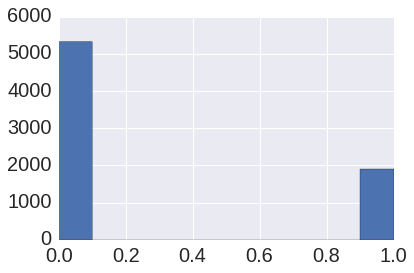

In [74]:
cell_tissue_similarity_df['same_cell_tissue_gbcc'].hist()

In [75]:
cell_tissue_similarity_df.head()

,c_x,c_y,same_cell_tissue_gbcc
0,22RV1,22RV1,1
1,22RV1,647-V,0
2,22RV1,A549,0
3,22RV1,BFTC-905,0
4,22RV1,BT-20,0


In [76]:
db.import_table(
    cell_tissue_similarity_df, 
    'cell_info_gbcc', [
        [('c_x', 'c_y'), True],
        [('c_y', 'c_x'), False],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbcc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: 'xxx.xxx.xxx.xxx'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Loading data into MySQL table: 'cell_info_gbcc'...
INFO:csv2sql.core:mysql  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbcc.tsv' into table `cell_info_gbcc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbcc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/cell_info_gbcc.tsv'
DEBUG:csv2sql.core:Running locally
DEBU

### Cell cell correlation

In [77]:
mutations.head(2)

,g,accession_number,gene_cds_length,hgnc_id,c,id_sample,id_tumour,primary_site,site_subtype,primary_histology,histology_subtype,genome_wide_screen,mutation_id,mutation_cds,mutation_aa,mutation_description,mutation_zygosity,grch,mutation_genome_position,strand,snp,fathmm_prediction,mutation_somatic_status,pubmed_pmid,id_study,institute,institute_address,catalogue_number,sample_source,tumour_origin,age,comments,f_mutation_very_bad,f_mutation_maybe_bad,f_mutation_mild,f_homozygous,f_snp,f_maybe_somatic
0,FRMD4A,ENST00000357447,3120,25491,HCC1806,907047,824559,breast,NS,carcinoma,ductal_carcinoma,y,COSM109920,c.1049C>T,p.S350L,Substitution - Missense,het,38,10:13693966-13693966,-,n,PASSENGER/OTHER,Reported in another cancer sample as somatic,NaN,NaN,American Type Culture Collection (ATCC),"P.O. Box 1549, Manassas, VA 20108, USA",CRL-2335,cell-line,primary,60,"Grade:II,Stage:II",0,1,0,0,0,1
1,LILRB1,ENST00000396331,1953,6605,HCC1806,907047,824559,breast,NS,carcinoma,ductal_carcinoma,y,COSM162161,c.1690G>A,p.E564K,Substitution - Missense,het,38,19:54636536-54636536,+,n,PASSENGER/OTHER,Reported in another cancer sample as somatic,NaN,NaN,American Type Culture Collection (ATCC),"P.O. Box 1549, Manassas, VA 20108, USA",CRL-2335,cell-line,primary,60,"Grade:II,Stage:II",0,1,0,0,0,1


In [78]:
mutations_gbgc.head(2)

,g,c,f_mutation_maybe_bad_density_gbgc,f_snp_density_gbgc,f_maybe_somatic_density_gbgc,f_mutation_mild_density_gbgc,f_mutation_very_bad_density_gbgc,f_mutation_density_gbgc,f_homozygous_density_gbgc
0,A1BG,CAL-51,0,0,0,0.000672,0,0.000672,0
1,A1BG,HCC1500,0,0,0,0.000672,0,0.000672,0


In [79]:
pivot_df = mutations_gbgc.pivot(index='g', columns='c')

In [80]:
pivot_df['f_mutation_very_bad_density_gbgc'][['22RV1', '647-V']].head()

c,22RV1,647-V
g,,
A1BG,NaN,NaN
A1CF,0,NaN
A1CF_ENST00000282641,0,NaN
A1CF_ENST00000373995,0,NaN
A2M,NaN,NaN


In [81]:
cc_distances = fn.get_cc_distance(
    pivot_df.fillna(0), css=css, row_subsets={'': None, 'cgs': cgs_genes, 'target': target_genes}
)

column_subsets: {'f_mutation_maybe_bad_density_gbgc': ('f_mutation_maybe_bad_density_gbgc',), 'f_mutation_very_bad_density_gbgc': ('f_mutation_very_bad_density_gbgc',), 'f_mutation_density_gbgc': ('f_mutation_density_gbgc',), 'f_maybe_somatic_density_gbgc': ('f_maybe_somatic_density_gbgc',), 'f_mutation_mild_density_gbgc': ('f_mutation_mild_density_gbgc',), 'f_homozygous_density_gbgc': ('f_homozygous_density_gbgc',), 'f_snp_density_gbgc': ('f_snp_density_gbgc',)}


/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [82]:
cc_distances.head()

,metric,corr,pvalue,count,PW,feature_subset_name,row_subset_name,corr_abs
4,sqeuclidean,0.265967,6.821358e-116,7140,x y f_mutation_may...,f_mutation_maybe_bad_density_gbgc,,0.265967
2,cityblock,0.374227,3.495295e-236,7140,x y f_mutation_ver...,f_mutation_very_bad_density_gbgc,,0.374227
2,cityblock,0.280043,8.687262e-129,7140,x y f_mutation_den...,f_mutation_density_gbgc,,0.280043
4,sqeuclidean,0.530915,0.000000e+00,7140,x y f_maybe_somati...,f_maybe_somatic_density_gbgc,,0.530915
13,matching,0.279825,1.395384e-128,7140,x y f_mutation_mil...,f_mutation_mild_density_gbgc,,0.279825


In [83]:
mutations_gbcc = (
    cc_distances.iloc[0]['PW']
    .drop(pd.Index(['score_diff']), axis=1)
    .rename(columns={'x': 'c_x', 'y': 'c_y'})
)
display(mutations_gbcc.head())

for i in range(1, len(cc_distances)):
    df_other = (
        cc_distances.iloc[i]['PW']
        .drop(pd.Index(['score_diff']), axis=1)
        .rename(columns={'x': 'c_x', 'y': 'c_y'})
    )   
    mutations_gbcc = mutations_gbcc.merge(df_other, on=['c_x', 'c_y'], how='outer')
display(mutations_gbcc.head())

,c_x,c_y,f_mutation_maybe_bad_density_gbgc_sqeuclidean
1,647-V,22RV1,0.001500
2,A549,22RV1,0.001339
3,BFTC-905,22RV1,0.001731
4,BT-20,22RV1,0.001388
5,BT-474,22RV1,0.001738


,c_x,c_y,f_mutation_maybe_bad_density_gbgc_sqeuclidean,f_mutation_very_bad_density_gbgc_cityblock,f_mutation_density_gbgc_cityblock,f_maybe_somatic_density_gbgc_sqeuclidean,f_mutation_mild_density_gbgc_matching,f_homozygous_density_gbgc_sokalmichener,f_snp_density_gbgc_sokalmichener,f_mutation_maybe_bad_density_gbgc_sstarget_matching,f_mutation_very_bad_density_gbgc_sstarget_matching,f_mutation_density_gbgc_sstarget_matching,f_maybe_somatic_density_gbgc_sstarget_sqeuclidean,f_mutation_mild_density_gbgc_sstarget_canberra,f_homozygous_density_gbgc_sstarget_sqeuclidean,f_snp_density_gbgc_sstarget_correlation,f_mutation_maybe_bad_density_gbgc_sscgs_cityblock,f_mutation_very_bad_density_gbgc_sscgs_matching,f_mutation_density_gbgc_sscgs_cityblock,f_maybe_somatic_density_gbgc_sscgs_matching,f_mutation_mild_density_gbgc_sscgs_sqeuclidean,f_homozygous_density_gbgc_sscgs_yule,f_snp_density_gbgc_sscgs_euclidean
0,647-V,22RV1,0.001500,0.412260,2.413418,0.000225,0.044924,0.017414,0.008697,0.114943,0.017241,0.183908,7.476030e-07,10,1.900168e-07,NaN,0.027031,0.056604,0.054533,0.054245,0.000005,2,0.000639
1,A549,22RV1,0.001339,0.395590,2.209933,0.000268,0.040365,0.012876,0.007364,0.103448,0.017241,0.155172,7.476030e-07,7,5.239601e-07,NaN,0.027547,0.056604,0.056384,0.063679,0.000005,2,0.000938
2,BFTC-905,22RV1,0.001731,0.399189,2.453866,0.000225,0.048236,0.023807,0.009173,0.126437,0.017241,0.178161,7.476030e-07,6,1.665301e-06,NaN,0.025615,0.051887,0.049015,0.051887,0.000006,2,0.000639
3,BT-20,22RV1,0.001388,0.393069,2.267103,0.000253,0.043581,0.012970,0.007269,0.103448,0.022989,0.160920,7.476030e-07,6,7.178547e-07,NaN,0.027872,0.051887,0.057381,0.047170,0.000010,2,0.000639
4,BT-474,22RV1,0.001738,0.432597,2.701113,0.000237,0.051116,0.012212,0.008412,0.120690,0.017241,0.166667,6.503726e-07,8,5.239601e-07,NaN,0.034414,0.058962,0.062784,0.056604,0.000009,2,0.000639


In [84]:
!ls /home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbcc.tsv -al

ls: cannot access /home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbcc.tsv: No such file or directory


In [85]:
db.import_table(
    mutations_gbcc, 
    'mutations_gbcc', [
        [('c_x', 'c_y'), True],
        [('c_y', 'c_x'), False],
    ],
)

DEBUG:csv2sql.core:Uncompressing file...
INFO:csv2sql.core:bzip2 -dkf '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbcc.tsv.bz2'
DEBUG:csv2sql.core:Running on host: 'xxx.xxx.xxx.xxx'
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 


FML
FML
FML

DEBUG:csv2sql.core:Loading data into MySQL table: 'mutations_gbcc'...
INFO:csv2sql.core:mysql  az_dream_2015_features -e "load data local infile '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbcc.tsv' into table `mutations_gbcc` ignore 1 lines;  show warnings;" 
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 
DEBUG:csv2sql.core:Removing uncompressed file '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbcc.tsv'...
INFO:csv2sql.core:rm -f '/home/kimlab1/database_data/biodata/recipes/az_dream_2015/notebooks/cnv/mutations_gbcc.tsv'
DEBUG:csv2sql.core:Running locally
DEBUG:csv2sql.core:Command ran successfully!
DEBUG:csv2sql.core:output: 


# Finalize

In [ ]:
print(datetime.datetime.now())